In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

In [44]:
data = pd.read_csv(r"C:\Users\himan\Desktop\7th GAN\DATASETS\KolkataCovidcsv.csv")
data

,From Date,PM2.5,NO2,Ozone,RH,WS,WD,SR,BP,RF,AT
0,01-01-2019 00:00,394.25,152.37,2.76,62.99,0.42,277.44,27.10,1014.83,0.0,NaN
1,01-01-2019 01:00,378.42,113.75,7.05,63.95,0.12,160.12,25.62,1014.62,0.0,NaN
2,01-01-2019 02:00,327.53,80.52,17.08,63.71,0.05,140.24,25.60,1014.45,0.0,NaN
3,01-01-2019 03:00,269.73,70.08,22.70,64.50,0.10,93.69,26.36,1014.38,0.0,NaN
4,01-01-2019 04:00,261.55,71.10,18.08,68.11,0.11,165.27,27.16,1014.53,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35059,31-12-2022 19:00,152.97,0.56,20.55,67.77,0.26,181.56,7.84,1012.32,0.0,19.91
35060,31-12-2022 20:00,161.85,0.24,19.60,70.19,0.38,168.70,7.69,1012.82,0.0,19.47
35061,31-12-2022 21:00,159.56,0.63,15.35,72.02,0.51,279.40,7.70,1013.48,0.0,19.10
35062,31-12-2022 22:00,168.30,9.49,10.30,75.61,0.52,283.48,7.45,1013.53,0.0,18.64


In [45]:
data = data.drop(columns=[ 'From Date'])

In [46]:
# Replaceing NaN values with 0
data.fillna(0, inplace=True)

In [47]:
#  dataset has columns for features and a target variable

feature_columns = ['PM2.5'	,'NO2'	,'Ozone'	,'RH'	,'WS'	,'WD'	,'SR'	,'BP'	,'RF'	,'AT']
target_column = 'PM2.5'

In [48]:
# Splitting the dataset into features and target variable
X = data[feature_columns].values
y = data[target_column].values

In [49]:
# Normalizing the feature values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [50]:
# sliding window parameters
window_size = 5  # Number of past time steps considered
output_size = 10  # Number of steps ahead used to predict pollutant concentration

In [51]:
# Create 3D dataset using sliding window technique
def create_dataset(X, y, window_size, output_size):
    X_windowed = []
    y_windowed = []
    for i in range(len(X) - window_size - output_size + 1):
        X_windowed.append(X[i:i+window_size])
        y_windowed.append(y[i+window_size:i+window_size+output_size])
    return np.array(X_windowed), np.array(y_windowed)

X_windowed, y_windowed = create_dataset(X_scaled, y, window_size, output_size)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

In [53]:
# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(output_size))  # Output layer with 'output_size' neurons for multi-step ahead prediction
model.compile(optimizer='adam', loss='mse')

In [54]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
877/877 [==============================] - 33s 19ms/step - loss: 5369.0923 - val_loss: 3336.8650
Epoch 2/50
877/877 [==============================] - 12s 14ms/step - loss: 2750.7544 - val_loss: 2107.1042
Epoch 3/50
877/877 [==============================] - 12s 14ms/step - loss: 2008.5970 - val_loss: 1764.6796
Epoch 4/50
877/877 [==============================] - 12s 13ms/step - loss: 1743.3113 - val_loss: 1640.2748
Epoch 5/50
877/877 [==============================] - 13s 14ms/step - loss: 1611.2971 - val_loss: 1519.0807
Epoch 6/50
877/877 [==============================] - 12s 14ms/step - loss: 1517.9111 - val_loss: 1448.7418
Epoch 7/50
877/877 [==============================] - 11s 13ms/step - loss: 1453.9531 - val_loss: 1404.3901
Epoch 8/50
877/877 [==============================] - 11s 13ms/step - loss: 1403.5123 - val_loss: 1368.6350
Epoch 9/50
877/877 [==============================] - 11s 13ms/step - loss: 1363.0667 - val_loss: 1354.5183
Epoch 10/50
877/877 [=======

In [55]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

220/220 [==============================] - 1s 6ms/step - loss: 1084.7870
Test Loss: 1084.7869873046875
220/220 [==============================] - 4s 6ms/step


In [56]:
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Calculate Fraction of predictions with a factor of 2 (FAC2)
def fac2(y_true, y_pred):
    within_factor = np.abs(y_true / y_pred) <= 2
    return np.mean(within_factor)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Correlation Coefficient (r)
r = np.corrcoef(np.ravel(y_test), np.ravel(predictions))[0, 1]

# Calculate Mean Gross Error (MGE)
mge = np.mean(np.abs(y_test - predictions))

# Calculate Mean Bias (MB)
mb = np.mean(y_test - predictions)

# Calculate Coefficient of Efficiency (COE)
coe = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

# Calculate Coefficient of Determination (R2 score)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f'Fraction of predictions with a factor of 2 (FAC2): {fac2(y_test, predictions)}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient (r): {r}')
print(f'Mean Gross Error (MGE): {mge}')
print(f'Mean Bias (MB): {mb}')
print(f'Coefficient of Efficiency (COE): {coe}')
print(f'Coefficient of Determination (R2 score): {r2}')

Fraction of predictions with a factor of 2 (FAC2): 0.9624393723252497
Root Mean Square Error (RMSE): 32.93610529895034
Correlation Coefficient (r): 0.8627112721686752
Mean Gross Error (MGE): 17.92471166831777
Mean Bias (MB): 2.126365053101375
Coefficient of Efficiency (COE): 0.7430698922426193
Coefficient of Determination (R2 score): 0.7425476739245742


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

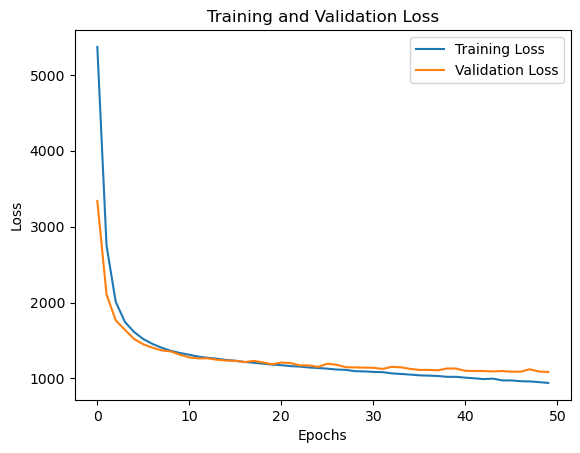

In [58]:

# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

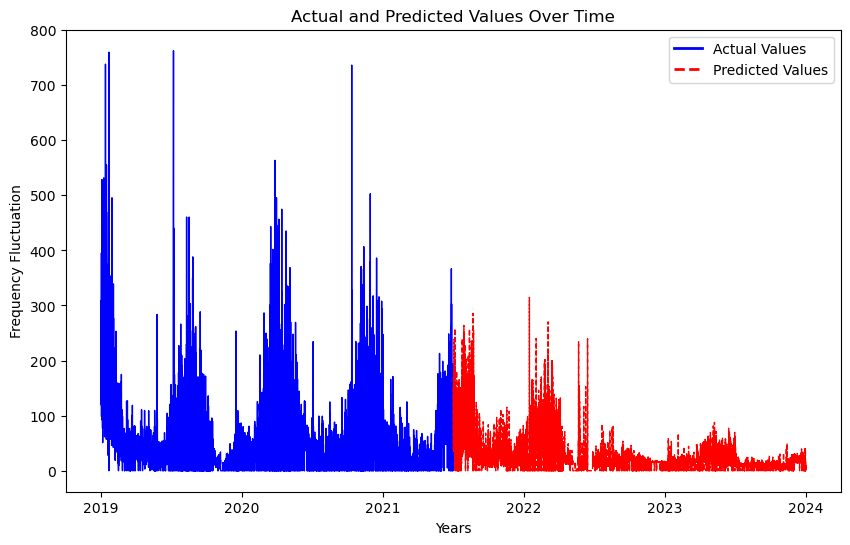

In [62]:
# Line plot of actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(y_test)), y_test, label='Actual Values', color='blue', linewidth=1)
plt.plot(range(len(y_test)-20, len(y_test)+len(predictions)-20), predictions, label='Predicted Values', color='red', linestyle='--', linewidth=1)
plt.title('Actual and Predicted Values Over Time')

# Adjusting x-axis to represent years
plt.xlabel('Years')
plt.ylabel('Frequency Fluctuation')

# Assuming y_test covers 80 data points (4 years) and predictions 20 data points (1 year)
# Adjust x-ticks based on total data points
total_points = len(y_test) + len(predictions)
plt.xticks(ticks=np.linspace(0, total_points, 6), labels=['2019', '2020', '2021', '2022', '2023', '2024'])

# Create custom legend handles
actual_handle = plt.Line2D([], [], color='blue', linewidth=2, label='Actual Values')
predicted_handle = plt.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Predicted Values')

# Add the legend with custom handles
plt.legend(handles=[actual_handle, predicted_handle])
plt.show()

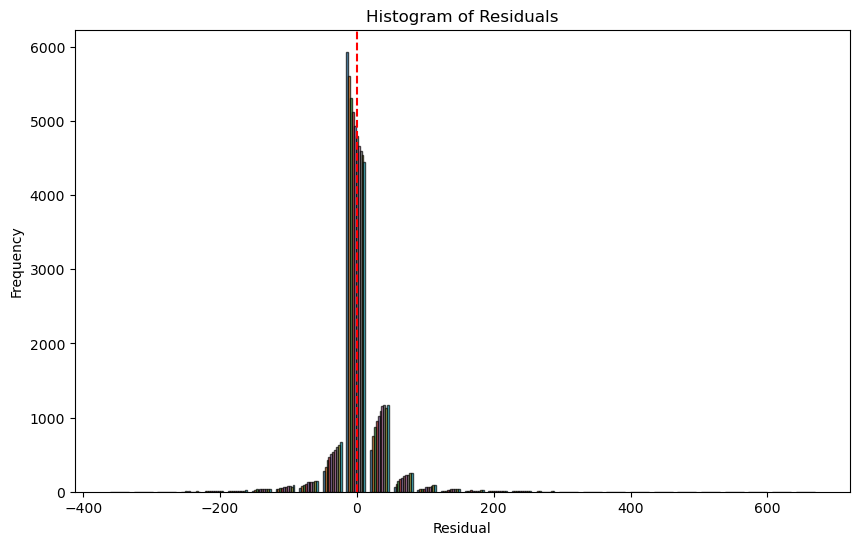

In [59]:
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()
